In [1]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [41]:
headlines = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json',
                         lines = True)

Let's just make sure that the observations corresponding to the two labels (**is_sarcastic = 0, 1**) are balanced. We see that there are 14,985 of headlines that have been identified as not sarcastic and 13,634 of headlines that have been identified as sarcastic. We are going to sample 10,000 observations from each label. 

In [43]:
headlines.is_sarcastic.value_counts()
headlines = headlines.groupby('is_sarcastic').sample(10000)

In [44]:
headlines.is_sarcastic.value_counts()

0    10000
1    10000
Name: is_sarcastic, dtype: int64

## Split Data into Train and Validation Data

After working on the first notebook, I realized that we should probably use the test data set, instead of the validation data set, to evaluate the final performance of the model. Hence, when splitting the data set, we allocated 15% of all observations to the validation and test data sets. This can be done using the line of code below:

In [45]:
train_df, val_df, test_df = np.split(headlines.sample(frac = 1), 
                                     [int(0.7 * len(headlines)), int(0.85 * len(headlines))])

In [46]:
print("Number of observations in training data set: {}".format(len(train_df)))
print("Number of observations in validation data set: {}".format(len(val_df)))
print("Number of observations in test data set: {}".format(len(test_df)))

Number of observations in training data set: 14000
Number of observations in validation data set: 3000
Number of observations in test data set: 3000


In [57]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.headline, train_df.is_sarcastic)).shuffle(len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df.headline, val_df.is_sarcastic)).shuffle(len(val_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.headline, test_df.is_sarcastic)).shuffle(len(test_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Classifier using BERT and LSTMs

Here, we are going to build a classifier model that uses both BERT and LSTMs. We made the decision to add a Bi-directional LSTM layer to the BERT-based classifier as we figured that sarcasm may have a lot to do with word order as much as it has to do with the meaning of the sentences. So, instead of using the **pooled_output** of the BERT encoder (which represents the entire input sequence as a *pooled* single embedding), we use the **sequence_output** which is a sequence of embeddings where each embedding corresponds to a token inside the input sequence. That way, we can take the hierarchical (sequential) structure of the input text into consideration.

In [58]:
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2"

preprocess_layer = hub.KerasLayer(PREPROCESS_MODEL)
encoder_layer = hub.KerasLayer(BERT_MODEL)

In [59]:
input_layer = tf.keras.layers.Input(shape = (), dtype = tf.string)
bert_input = preprocess_layer(input_layer)
bert_output = encoder_layer(bert_input)

output = tf.keras.layers.Dropout(0.3)(bert_output['sequence_output'])
output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(output)
output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)

model = tf.keras.Model(inputs = [input_layer], outputs = output)
model.compile(optimizer = tf.keras.optimizers.AdamW(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [61]:
history = model.fit(train_dataset, 
                    validation_data = val_dataset,
                    epochs = 30, 
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7629
Epoch 1: val_loss improved from inf to 0.42141, saving model to model/best_performed_model.ckpt
110/110 [==============================] - 260s 2s/step - loss: 0.4822 - accuracy: 0.7629 - val_loss: 0.4214 - val_accuracy: 0.8023
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8402
Epoch 2: val_loss improved from 0.42141 to 0.35204, saving model to model/best_performed_model.ckpt
110/110 [==============================] - 246s 2s/step - loss: 0.3536 - accuracy: 0.8402 - val_loss: 0.3520 - val_accuracy: 0.8363
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8698
Epoch 3: val_loss improved from 0.35204 to 0.34111, saving model to model/best_performed_model.ckpt
110/110 [==============================] - 247s 2s/step - loss: 0.3043 - accuracy: 0.8698 - val_loss: 0.3411 - val_accuracy: 0.8473
Epoch 4/30
110/110 [

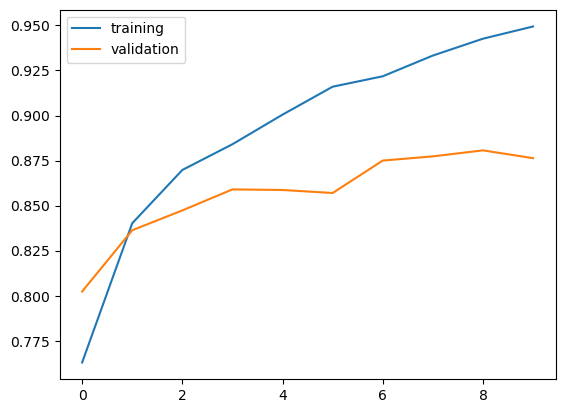

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

## Test the Model

In [63]:
model.evaluate(test_dataset)

24/24 [==============================] - 43s 2s/step - loss: 0.3895 - accuracy: 0.8617


[0.3894980549812317, 0.8616666793823242]

The model performs pretty well with **86.17%** test accuracy. To the best of my knowledge, there is no public leaderboard (such as the disaster tweets one) that we can use to compare the performance of this model with respect to others, but from what I have seen in other notebooks, this is a decent performance. Although not a direct test of causality, the performance of this model relative to the previous one without the bi-directional LSTM layer suggests that taking word order into account may be helpful in detecting sarcasm in headlines. 